In [20]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel

In [21]:
dataset = pd.read_csv("../../data/processed/cleaned_twitch_messages.csv")

In [22]:
df = pd.DataFrame(dataset["message"])

In [23]:
df

,message
0,eccoci
1,onesta reazione
2,yo
3,stiamo cucinando
4,eccoci
...,...
43295,a piu tardi
43296,canale telegram per rimanere sempre aggiornati
43297,vacci
43298,minaaoheart


# Clustering
https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95

## TF-IDF vectorization

In [24]:
print("Embedding with method: Tf-Idf")

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['message']).toarray()

Embedding with method: Tf-Idf


## Sentence transformer

In [25]:
print("Embedding with method: Sentence transformer")

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['message'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

Embedding with method: Sentence transformer
Elapsed time: 551.77 seconds


## GloVe

In [26]:
#embeddings = GloVe(name='6B', dim=100)
#
## Set the maximum sentence length and embedding dimension
#max_length = 100 
#embedding_dim = 100
#
## define a function to convert a sentence to a fixed-size vector using GloVe embeddings
#def sentence_embedding(sentence):
#    words = sentence.split()
#    num_words = min(len(words), max_length)
#    embedding_sentence = np.zeros((max_length, embedding_dim))
#    
#    for i in range(num_words):
#        word = words[i]
#        if word in embeddings.stoi:
#            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
#            
#    return embedding_sentence.flatten()
#
#df['encode_glove'] = df['text_cleaned'].apply(lambda sentence: sentence_embedding(sentence))
#X_glove = np.vstack(df['encode_glove'])

## BERT - [CLS] token for sentence context

In [27]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

In [28]:
print("Embedding with method: BERT-[CLS]")

st = time.time()
df['cls_bert'] = df['message'].apply(lambda sentence: get_cls_sentence(sentence))
et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_cls_bert = np.vstack(df['cls_bert'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Embedding with method: BERT-[CLS]
Elapsed time: 2569.37 seconds


## Salvataggio dei risultati

In [29]:
df.to_csv("../../data/processed/twitch_messages_with_embeddings.csv", index=False)

## Clustering e visualizzazione

In [ ]:
#def eval_cluster(embedding, kmeans):
#    y_pred = kmeans.fit_predict(embedding)
#    
#    # Evaluate the performance using ARI, NMI, and FMI
#    ari = adjusted_rand_score(df["target"], y_pred)
#    nmi = normalized_mutual_info_score(df["target"], y_pred)
#    fmi = fowlkes_mallows_score(df["target"], y_pred)
#
#    # Print Metrics scores
#    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
#    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
#    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [31]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1

In [32]:
def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"KMeans clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

Clustering and visualization


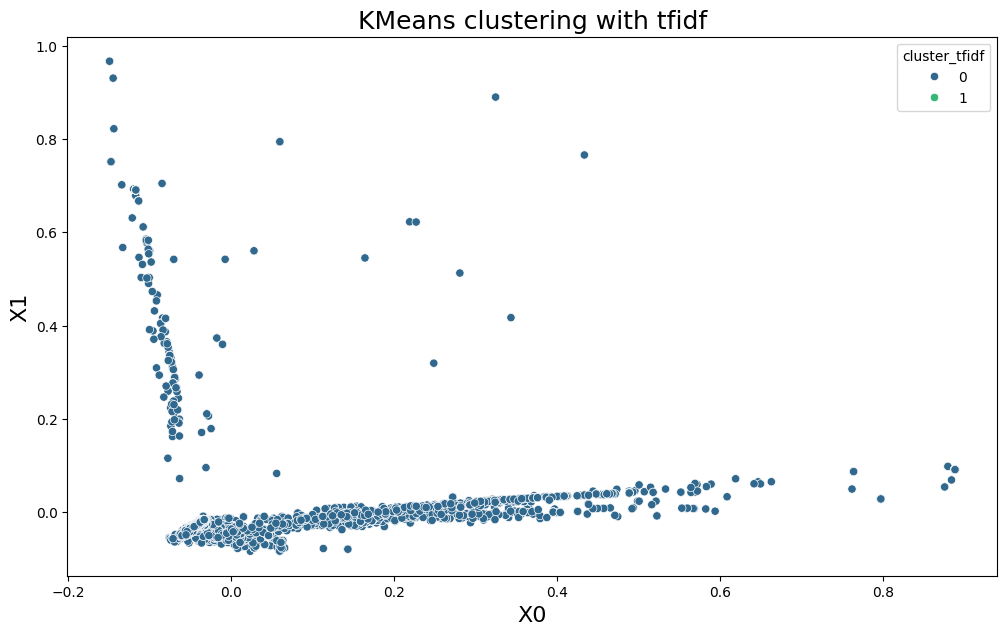

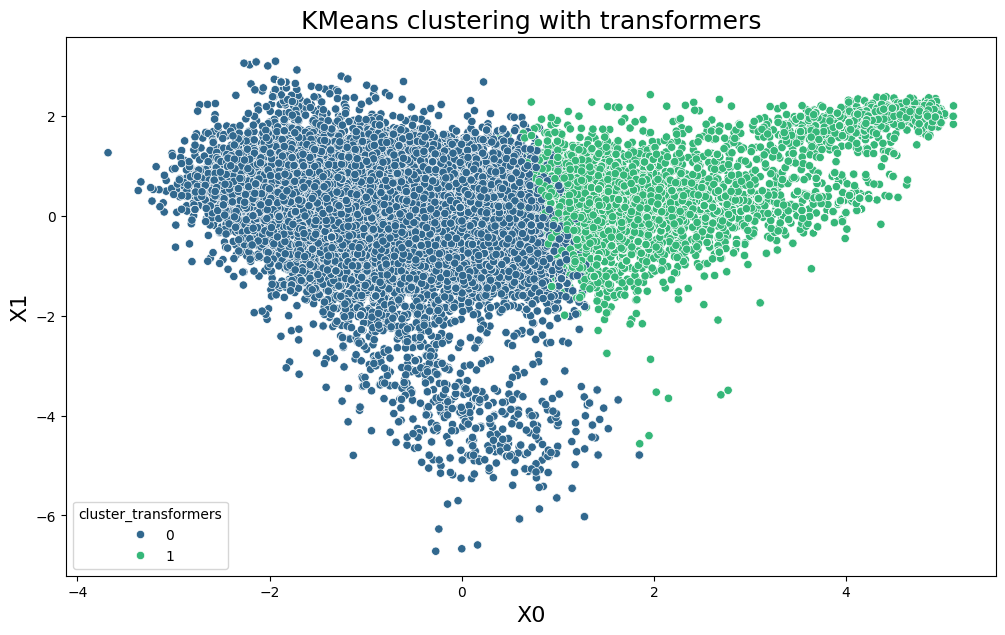

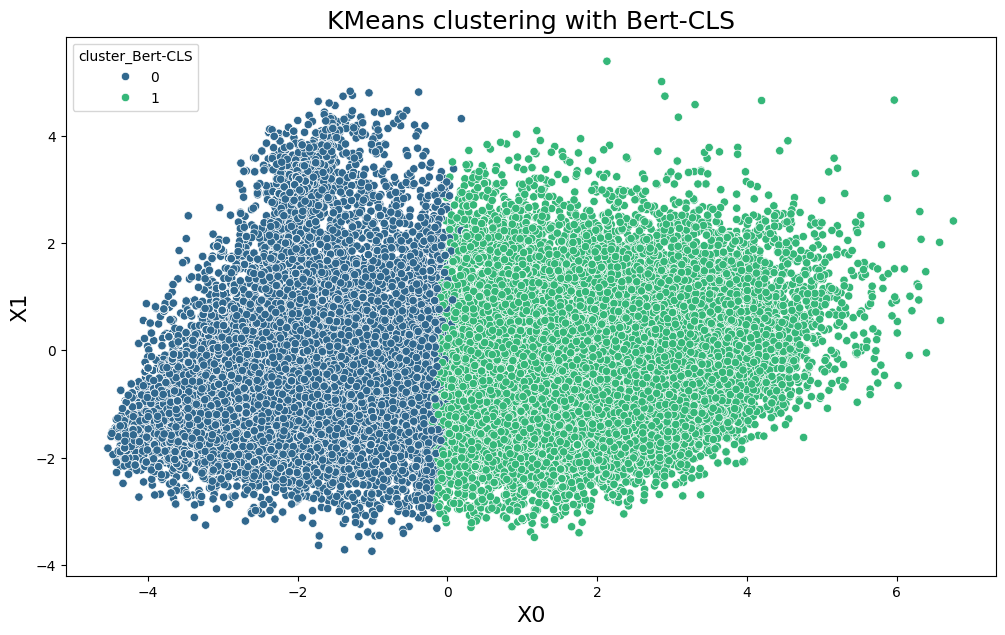

In [36]:
print("Clustering and visualization")

for embedding_and_method in [(X, 'tfidf'), (X_transformers, 'transformers'), ((X_cls_bert, 'Bert-CLS')) ]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=2, random_state=79872435)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters
    
    #eval_cluster(embedding, kmeans)
    
    dimension_reduction(embedding, method)
    
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)

In [37]:
df

,message,encode_transforemers,cls_bert,cluster_tfidf,x0_tfidf,x1_tfidf,cluster_transformers,x0_transformers,x1_transformers,cluster_Bert-CLS,x0_Bert-CLS,x1_Bert-CLS
0,eccoci,"[-0.35966235, 0.3134319, -0.523774, 0.0087574,...","[tensor(-0.4351), tensor(-0.2392), tensor(-0.1...",0,-0.034265,-0.017043,0,-0.957816,-0.251434,0,-2.242735,-0.772635
1,onesta reazione,"[-0.65648603, 0.24438457, -0.43212256, -0.0071...","[tensor(-0.5008), tensor(-0.2649), tensor(0.09...",0,-0.033695,-0.016759,0,0.448498,-0.108248,1,0.806447,-1.361306
2,yo,"[-0.15303254, 0.25612843, 0.21914099, -0.16111...","[tensor(-0.0208), tensor(0.2422), tensor(0.023...",0,-0.069058,-0.048686,1,4.236799,0.352798,0,-3.006580,0.746975
3,stiamo cucinando,"[-0.12108151, 0.51124024, -0.6737351, 0.393994...","[tensor(-0.4355), tensor(0.1697), tensor(0.092...",0,-0.149582,0.967220,0,-1.879450,2.686046,1,0.949054,-0.382452
4,eccoci,"[-0.35966235, 0.3134319, -0.523774, 0.0087574,...","[tensor(-0.4351), tensor(-0.2392), tensor(-0.1...",0,-0.034265,-0.017043,0,-0.957816,-0.251434,0,-2.242735,-0.772635
...,...,...,...,...,...,...,...,...,...,...,...,...
43295,a piu tardi,"[-0.5110479, 0.64843863, 0.018340591, 0.043520...","[tensor(-0.3143), tensor(-0.2253), tensor(-0.1...",0,-0.034312,-0.017386,0,0.111980,-0.568113,0,-0.989710,-1.253842
43296,canale telegram per rimanere sempre aggiornati,"[-0.29531074, 0.15423153, -0.24130762, -0.6281...","[tensor(-0.5967), tensor(0.0411), tensor(0.188...",0,-0.038198,-0.021899,0,-1.354086,-0.422323,1,1.735772,-1.763230
43297,vacci,"[0.2528965, 0.52432066, -0.7266121, 0.09755216...","[tensor(-0.1778), tensor(-0.2591), tensor(-0.2...",0,-0.033616,-0.016663,1,1.000490,1.176617,0,-2.577226,-2.082204
43298,minaaoheart,"[0.056984533, -0.03974762, 0.44687185, 0.37210...","[tensor(-0.3816), tensor(-0.0171), tensor(-0.4...",0,-0.033363,-0.016452,0,0.001717,-0.097963,0,-3.189280,-1.200842


Il calcolo degli embeddings ha impiegato circa
- 9min con il sentence transformer
- 42min con BERT-[CLS]
il file risultante è tipo 700MB.

Se i messaggi al confine tra le due classi sono difficili da separare, quindi considerati simili, allora i messaggi più diversi (e quindi quelli tossici forse???) dovrebbero trovarsi agli estremi. Quindi bisognerebbe selezionare questi punti, che sarebbero i più lontani dai centroidi.